In [1]:
# %load /home/jonathan/.ipython/profile_default/startup/01-setup.py
# start up settings for jupyter notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys

# use plt.style.available() to check out available styles
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 15.0
plt.rcParams['axes.labelsize'] = 15.0
plt.rcParams['xtick.labelsize'] = 15.0
plt.rcParams['ytick.labelsize'] = 15.0
plt.rcParams['legend.fontsize'] = 15.0

%matplotlib inline

# set the max column width
pd.options.display.max_colwidth = 1000

# to avoid have warnings from chained assignments
pd.options.mode.chained_assignment = None


In [2]:
idx = pd.IndexSlice

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

### Load the data

In [3]:
fp = '../../prediction-data/final-data.csv'
uniq_fp = '../../prediction-data/uniq-final-data.csv'

base_df = pd.read_csv(fp, header=[0, 1])
base_df.rename(columns={
    'Unnamed: 0_level_1': '',
    'Unnamed: 1_level_1': '',
    'Unnamed: 2_level_1': '',
    'Unnamed: 3_level_1': ''
}, level=1, inplace=True)

uniq_base_df = pd.read_csv(uniq_fp, header=[0, 1])
uniq_base_df.rename(columns={
    'Unnamed: 0_level_1': '',
    'Unnamed: 1_level_1': '',
    'Unnamed: 2_level_1': '',
    'Unnamed: 3_level_1': ''
}, level=1, inplace=True)

def convert_time_cols(df):
    # convert time columns from us to s
    time_cols = list(filter(lambda c: 'time' in c.lower() and not 'number of times' in c.lower(), df.columns.get_level_values(level=1)))
    for time_col in time_cols:
        df.loc[:, (time_col, 'astar')] /= 1000000
        df.loc[:, (time_col, 'inc3')] /= 1000000
        df.loc[:, (time_col, 'recomp-astar')] /= 1000000
        df.loc[:, (time_col, 'recomp-inc3')] /= 1000000

    # rename from us to s
    renamed_time_cols = list(map(lambda col: col.replace('(us)', '(s)'), time_cols))
    renamed_cols_dict = dict(zip(time_cols, renamed_time_cols))
    df.rename(columns=renamed_cols_dict, level=0, inplace=True)
    df.rename(columns=renamed_cols_dict, level=1, inplace=True)
    
convert_time_cols(base_df)
convert_time_cols(uniq_base_df)

base_df.set_index(['model', 'log', 'decomposition', 'SP label'], inplace=True)
uniq_base_df.set_index(['model', 'log', 'decomposition', 'SP label'], inplace=True)

# filter by k=2
k = 2
k_diff = base_df.loc[:, ('Total Time including setup (s)', 'max_diff')] >= k
k2_df = base_df.loc[k_diff, :]

k_diff_uniq = uniq_base_df.loc[:, ('Total Time including setup (s)', 'max_diff')] >= k
k2_uniq_df = uniq_base_df.loc[k_diff_uniq, :]

print('Base df shape: {}'.format(base_df.shape))
print('Uniq base df shape: {}'.format(uniq_base_df.shape))
print('K-2 df shape: {}'.format(k2_df.shape))
print('K-2 unique df shape: {}'.format(k2_uniq_df.shape))

/home/jonathan/2018/code/alignment-algorithm-classifier/alignclf-venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Base df shape: (245478, 258)
Uniq base df shape: (185848, 258)
K-2 df shape: (86469, 258)
K-2 unique df shape: (74582, 258)


In [7]:
generic_50 = base_df.index.get_level_values('decomposition') == 'generic_50'
base_df.loc[~generic_50, :].shape[0]

135796

In [7]:
base_df.index.get_level_values('model').unique()

Index(['P430', 'P297', 'P381', 'P307', 'P383', 'P347', 'P436', 'P313', 'net5',
       'net1', 'net2', 'net4', 'net3', 'P272', 'P285', 'P284', 'P291', 'P246',
       'P241', 'P275'],
      dtype='object', name='model')

### Map the class names to values

In [8]:
class_map = {
    'astar': 0,
    'inc3': 1,
    'recomp-astar': 2,
    'recomp-inc3': 3
}

base_df.loc[:, ('Min', 'Total Time including setup (s) - id')] = base_df.loc[: , idx['Min', 'Total Time including setup (s)']].map(class_map)
base_df.loc[:, ('is_valid', 'all')] = base_df.loc[:, idx[('is_valid'), ('astar', 'inc3', 'recomp-astar', 'recomp-inc3')]].apply(lambda row: row.all(), axis=1)


/home/jonathan/2018/code/alignment-algorithm-classifier/alignclf-venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2819: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


### Load the extra features

In [ ]:
extra_feature_dp = '../../prediction-data/features'

extra_feature_fname_list = list(os.listdir(extra_feature_dp))
extra_feature_fname_list = list(filter(lambda fp: 'extra-extra' in fp, extra_feature_fname_list))

for fname in extra_feature_fp_list:
    fp = os.path.join(extra_feature_dp, fname)
    

### Analyze invalid instances

### Infeasible for incremental 3

In [38]:
invalid_inc3 = base_df.loc[:, ('is_valid', 'inc3')] == False
invalid_inc3_df = base_df.loc[invalid_inc3, :]


In [81]:
def get_extra_stats(name, result_dir, colnames):
    model, log, decomposition, caseid = name
    split_path = result_dir.split('/')
    split_path[2] = 'clst_2018_12'
    split_path[0] = '../..'
    modified_dir = os.sep.join(split_path)
    
    stats_fp = os.path.join(modified_dir, 'trace-stats.csv')
    
    if not os.path.isfile(stats_fp):
        print('Not file: {}'.format(stats_fp))
        return pd.Series([np.nan for _ in range(len(colnames))], index=colnames)
#     print(stats_fp)
#     print(caseid)
    stats_df = pd.read_csv(stats_fp)
    caseid_row_condition = stats_df.loc[:, 'SP label'] == str(caseid)
    extra_stats = stats_df.loc[caseid_row_condition, colnames]
    extra_stats.index = pd.MultiIndex.from_tuples([name], names=['model', 'log', 'decomposition', 'SP label'])
    return extra_stats



In [82]:
invalid_inc3_df.iloc[0, :].name

('net2', 'net2-10-60-l5000', 'generic_50', 2819)

In [96]:
import time 

In [112]:
extra_stats_colnames = [
    'Number of splits when splitting marking',
    'Number of times replay was restarted',
    'Size of the constraintset',
    'Time to compute heuristics (us)'
]

start = time.time()
extra_stats_inc3_df_list = invalid_inc3_df.apply(lambda row: get_extra_stats(row.name, row['result_dir'].values[1], extra_stats_colnames), axis=1)
extra_stats_inc3_df = pd.concat(list(extra_stats_inc3_df_list))
end = time.time()
print('Took {:.2f}s'.format(end - start))
extra_stats_inc3_df['Time to compute heuristics (us)'] /= 1000000
extra_stats_inc3_df.columns = pd.MultiIndex.from_product([extra_stats_inc3_df.columns, ['inc3']])
invalid_inc3_df = extra_stats_inc3_df.merge(invalid_inc3_df, on=['model', 'log', 'decomposition', 'SP label'])

Took 1.25s


In [89]:
invalid_inc3_df.columns.get_level_values(level=0).unique()

Index(['Number of splits when splitting marking',
       'Number of times replay was restarted', 'Size of the constraintset',
       'Time to compute heuristics (us)', 'Cost of the alignment',
       'Heuristics computed', 'Heuristics derived', 'Heuristics estimated',
       'Markings added to closed set', 'Markings polled from queue',
       'Markings queued', 'Markings reached', 'Min',
       'Time to compute alignment (s)', 'Total Time including setup (s)',
       'is_valid', 'n_invis_move', 'n_log_move', 'n_model_move', 'n_sync_move',
       'result_dir', 'model_trace_features'],
      dtype='object')

In [10]:
level_0 = (
    'Number of splits when splitting marking',
    'Number of times replay was restarted',
    'Size of the constraintset',
    'Total Time including setup (s)',
    'Time to compute heuristics (us)'
)

invalid_inc3_df.loc[:, idx[level_0, :]]

Number of splits when splitting marking  \
                                                                                astar   
model log              decomposition SP label                                           
net5  net5-60-60-l5000 sese_25       4271                                           0   
net1  net1-60-60-l5000 generic_50    291                                            0   
                                     301                                            0   
                                     393                                            0   
                                     1650                                           0   
                                     1961                                           0   
                                     2284                                           0   
                                     2937                                           0   
                                     2958                                           0   
                                     3301                                           0   
                                     3394                                           0   
                                     3815                                           0   
net2  net2-60-60-l5000 generic_50    193                                            0   
                                     234                                            0   
                                     424                                            0   
                                     621                                            0   
                                     926                                            0   
                                     2211                                           0   
                                     2744                                           0   
                                     2819                                           0   
                                     3239                                           0   
                                     3426                                           0   
                                     3482                                           0   
                                     3910                                           0   
                                     4562                                           0   
                                     4763                                           0   
                                     4874                                           0   
      net2-10-60-l5000 generic_50    2819                                           0   
                                     3117                                           0   
      net2-60-60-l5000 sese_25       193                                            0   
                                     234                                            0   
                                     424                                            0   
                                     926                                            0   
                                     2744                                           0   
                                     2819                                           0   
                                     3426                                           0   
                                     3482                                           0   
                                     3910                                           0   
                                     4574                                           0   
                                     4874                                           0   
      net2-10-60-l5000 sese_25       2819                                           0   
                                     3117                                           0   
net1  net1-60-60-l5000 sese_25       291 

### Find out the number of restarts and splits when incremental 3 is valid

In [44]:
base_df.columns.get_level_values(level=0).unique()

Index(['Cost of the alignment', 'Heuristics computed', 'Heuristics derived',
       'Heuristics estimated', 'Markings added to closed set',
       'Markings polled from queue', 'Markings queued', 'Markings reached',
       'Min', 'Number of splits when splitting marking',
       'Number of times replay was restarted', 'Size of the constraintset',
       'Time to compute alignment (s)', 'Total Time including setup (s)',
       'is_valid', 'n_invis_move', 'n_log_move', 'n_model_move', 'n_sync_move',
       'result_dir', 'model_trace_features'],
      dtype='object')

In [46]:
non_fitting = base_df.loc[:, ('Cost of the alignment', 'inc3')] > 0
valid_inc3_df = base_df.loc[~invalid_inc3 & non_fitting, :]
extra_stats_colnames = [
    'Number of splits when splitting marking',
    'Number of times replay was restarted',
    'Size of the constraintset',
    'Time to compute heuristics (us)'
]

In [30]:
non_zero_restarts = k2_df.loc[:, ('Number of times replay was restarted', 'inc3')] > 0
k2_df.loc[non_zero_restarts, idx[tuple(extra_stats_colnames), :]].head() 

Number of splits when splitting marking       \
                                                                   astar inc3   
model log decomposition SP label                                                
P430  L19 sese_manual   case_435                                       0    4   
      L57 sese_manual   case_784                                       0    7   
                        case_167                                       0    5   
                        case_827                                       0    4   
                        case_399                                       0    5   

                                                           \
                                 recomp-astar recomp-inc3   
model log decomposition SP label                            
P430  L19 sese_manual   case_435            0          59   
      L57 sese_manual   case_784            0          59   
                        case_167            0          52   
                        case_827            0          62   
                        case_399            0          63   

                                 Number of times replay was restarted       \
                                                                astar inc3   
model log decomposition SP label                                             
P430  L19 sese_manual   case_435                                    0    1   
      L57 sese_manual   case_784                                    0    4   
                        case_167                                    0    2   
                        case_827                                    0    1   
                        case_399                                    0    2   

                                                           \
                                 recomp-astar recomp-inc3   
model log decomposition SP label                            
P430  L19 sese_manual   case_435            0           1   
      L57 sese_manual   case_784            0           1   
                        case_167            0           0   
                        case_827            0           0   
                        case_399            0           1   

                                 Size of the constraintset                    \
                                                     astar inc3 recomp-astar   
model log decomposition SP label                                               
P430  L19 sese_manual   case_435                         0    0            0   
      L57 sese_manual   case_784                         0    0            0   
                        case_167                         0    0            0   
                        case_827                         0    0            0   
                        case_399                         0    0            0   

                                              
                                 recomp-inc3  
model log decomposition SP label              
P430  L19 sese_manual   case_435           0  
      L57 sese_manual   case_784           0  
                        case_167           0  
                        case_827           0  
                        case_399           0

In [47]:
valid_inc3_df.loc[:, idx[tuple(extra_stats_colnames), :]].describe()

Number of splits when splitting marking                             \
                                        astar          inc3 recomp-astar   
count                                 65746.0  65746.000000      65746.0   
mean                                      0.0     11.260624          0.0   
std                                       0.0      8.855143          0.0   
min                                       0.0      3.000000          0.0   
25%                                       0.0      5.000000          0.0   
50%                                       0.0      8.000000          0.0   
75%                                       0.0     15.000000          0.0   
max                                       0.0     66.000000          0.0   

                    Number of times replay was restarted                \
        recomp-inc3                                astar          inc3   
count  65746.000000                              65746.0  65746.000000   
mean     127.655964                                  0.0      8.260624   
std       32.799821                                  0.0      8.855143   
min       19.000000                                  0.0      0.000000   
25%      116.000000                                  0.0      2.000000   
50%      128.000000                                  0.0      5.000000   
75%      143.000000                                  0.0     12.000000   
max      451.000000                                  0.0     63.000000   

                                 Size of the constraintset           \
      recomp-astar   recomp-inc3                     astar     inc3   
count      65746.0  65746.000000                   65746.0  65746.0   
mean           0.0     10.560779                       0.0      0.0   
std            0.0     12.963438                       0.0      0.0   
min            0.0      0.000000                       0.0      0.0   
25%            0.0      2.000000                       0.0      0.0   
50%            0.0      6.000000                       0.0      0.0   
75%            0.0     14.000000                       0.0      0.0   
max            0.0    115.000000                       0.0      0.0   

                                
      recomp-astar recomp-inc3  
count      65746.0     65746.0  
mean           0.0         0.0  
std            0.0         0.0  
min            0.0         0.0  
25%            0.0         0.0  
50%            0.0         0.0  
75%            0.0         0.0  
max            0.0         0.0

In [40]:
valid_inc3_df.loc[:, idx[tuple(extra_stats_colnames), :]].describe()

Number of splits when splitting marking                              \
                                        astar           inc3 recomp-astar   
count                                245426.0  245426.000000     245426.0   
mean                                      0.0       5.377226          0.0   
std                                       0.0       6.320828          0.0   
min                                       0.0       1.000000          0.0   
25%                                       0.0       3.000000          0.0   
50%                                       0.0       3.000000          0.0   
75%                                       0.0       4.000000          0.0   
max                                       0.0      83.000000          0.0   

                     Number of times replay was restarted                 \
         recomp-inc3                                astar           inc3   
count  245426.000000                             245426.0  245426.000000   
mean      115.948025                                  0.0       2.377262   
std        29.526300                                  0.0       6.320810   
min        14.000000                                  0.0       0.000000   
25%       109.000000                                  0.0       0.000000   
50%       117.000000                                  0.0       0.000000   
75%       126.000000                                  0.0       1.000000   
max       451.000000                                  0.0      80.000000   

                                  Size of the constraintset            \
      recomp-astar    recomp-inc3                     astar      inc3   
count     245426.0  245426.000000                  245426.0  245426.0   
mean           0.0       3.041691                       0.0       0.0   
std            0.0       9.023443                       0.0       0.0   
min            0.0       0.000000                       0.0       0.0   
25%            0.0       0.000000                       0.0       0.0   
50%            0.0       0.000000                       0.0       0.0   
75%            0.0       0.000000                       0.0       0.0   
max            0.0     141.000000                       0.0       0.0   

                                
      recomp-astar recomp-inc3  
count     245426.0    245426.0  
mean           0.0         0.0  
std            0.0         0.0  
min            0.0         0.0  
25%            0.0         0.0  
50%            0.0         0.0  
75%            0.0         0.0  
max            0.0         0.0

In [49]:
invalid_inc3 = base_df.loc[:, ('is_valid', 'inc3')] == False
base_df.loc[invalid_inc3, idx[tuple(extra_stats_colnames), :]].shape

(52, 12)

In [50]:
invalid_inc3_df.loc[:, idx[tuple(extra_stats_colnames), :]].describe()

Number of splits when splitting marking                          \
                                        astar       inc3 recomp-astar   
count                                    52.0  52.000000         52.0   
mean                                      0.0  46.211538          0.0   
std                                       0.0  21.047413          0.0   
min                                       0.0  28.000000          0.0   
25%                                       0.0  31.000000          0.0   
50%                                       0.0  34.000000          0.0   
75%                                       0.0  74.250000          0.0   
max                                       0.0  81.000000          0.0   

                  Number of times replay was restarted             \
      recomp-inc3                                astar       inc3   
count   52.000000                                 52.0  52.000000   
mean   197.192308                                  0.0  43.211538   
std     43.681574                                  0.0  21.047413   
min    157.000000                                  0.0  25.000000   
25%    164.000000                                  0.0  28.000000   
50%    172.000000                                  0.0  31.000000   
75%    252.750000                                  0.0  71.250000   
max    278.000000                                  0.0  78.000000   

                               Size of the constraintset                     \
      recomp-astar recomp-inc3                     astar  inc3 recomp-astar   
count         52.0   52.000000                      52.0  52.0         52.0   
mean           0.0   64.884615                       0.0   0.0          0.0   
std            0.0   38.574427                       0.0   0.0          0.0   
min            0.0   27.000000                       0.0   0.0          0.0   
25%            0.0   36.000000                       0.0   0.0          0.0   
50%            0.0   43.500000                       0.0   0.0          0.0   
75%            0.0  104.750000                       0.0   0.0          0.0   
max            0.0  133.000000                       0.0   0.0          0.0   

                   
      recomp-inc3  
count        52.0  
mean          0.0  
std           0.0  
min           0.0  
25%           0.0  
50%           0.0  
75%           0.0  
max           0.0

In [128]:
one_mag_faster = invalid_inc3_df.loc[:, ('Total Time including setup (s)', 'astar')] < 60
invalid_inc3_faster_df = invalid_inc3_df.loc[one_mag_faster, :]
invalid_inc3_df.loc[one_mag_faster, idx[('Number of splits when splitting marking', 'Number of times replay was restarted', 'Total Time including setup (s)', 'is_valid'), :]]

Number of splits when splitting marking  \
                                                                                 inc3   
model log              decomposition SP label                                           
net2  net2-10-60-l5000 generic_50    2819                                          34   
                                     3117                                          31   
      net2-60-60-l5000 generic_50    234                                           28   
                                     2744                                          28   
                                     2819                                          35   
                                     3426                                          29   
                                     3482                                          31   
                                     424                                           34   
                                     4562                                          35   
                                     926                                           28   
net5  net5-60-60-l5000 sese_25       4271                                          33   
net1  net1-60-60-l5000 sese_25       2284                                          31   
                                     2937                                          34   
                                     2958                                          31   
                                     3815                                          36   
net2  net2-10-60-l5000 sese_25       2819                                          34   
                                     3117                                          31   
      net2-60-60-l5000 sese_25       234                                           28   
                                     2744                                          28   
                                     2819                                          35   
                                     3426                                          29   
                                     3482                                          31   
                                     424                                           34   
                                     926                                           28   
net1  net1-60-60-l5000 generic_50    2284                                          31   
                                     2937                                          34   
                                     2958                                          31   
                                     3301                                          33   
                                     3815                                          36   

                                              Number of times replay was restarted  \
                                                                              inc3   
model log              decomposition SP label                                        
net2  net2-10-60-l5000 generic_50    2819                                       31   
                                     3117                                       28   
      net2-60-60-l5000 generic_50    234                                        25   
                                     2744                                       25   
                                     2819                                       32   
                                     3426                                       26   
                                     3482                                       28   
                                     424                                        31   
                                     4562                                       32   
                                     926                                        25   
net5  net5-60-60-l5000 sese_25       4271                                      

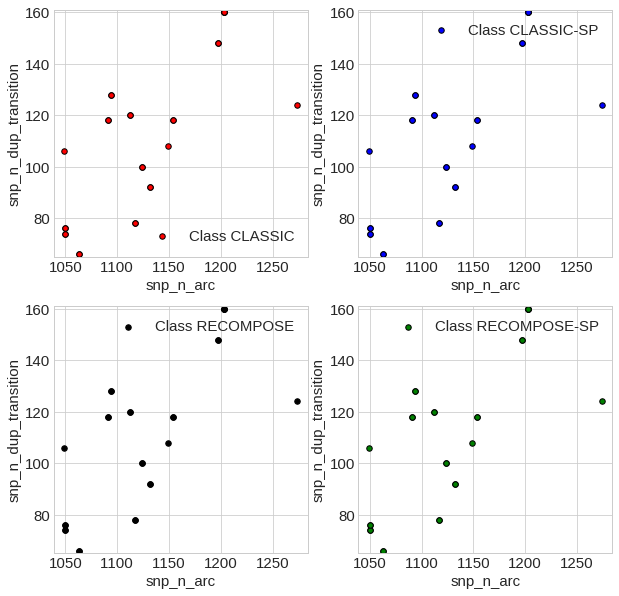

In [130]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(figsize=(10, 10), ncols=ncols, nrows=nrows)

class_names = [
    'CLASSIC', 'CLASSIC-SP', 'RECOMPOSE', 'RECOMPOSE-SP'
]

plot_colors = [
    'red', 'blue', 'black', 'green'
]
plot_step = 0.02

f1 = 'snp_n_dup_transition'
f0 = 'snp_n_arc'
X_df = invalid_inc3_faster_df.loc[:, idx[('model_trace_features'), (f0, f1)]]
X_df.columns = X_df.columns.droplevel(level=0)
X_df = X_df[[f0, f1]]
X = X_df.values

x_min, x_max = X[:, 0].min() - 10, X[:, 0].max() + 10
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

row = 0
col = 0

for i, n, c in zip(range(4), class_names, plot_colors):
    ax = axes[row, col]
    row = row if col < 1 else row + 1
    col = col + 1 if col < 1 else 0
#     ind = np.where(invalid_inc3_faster_df.loc[:, ('Min', 'Total Time including setup (s) - id')] == i)
    ax.scatter(X[:, 0], X[:, 1],
              c=c, cmap=plt.cm.Paired,
              s=30, edgecolor='k',
              label='Class {}'.format(n))
    
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_xlabel(X_df.columns[0])
    ax.set_ylabel(X_df.columns[1])
    ax.legend()

### Astar infeasible

In [115]:
invalid_astar = base_df.loc[:, ('is_valid', 'astar')] == False
invalid_astar_df = base_df.loc[invalid_astar, :]

In [165]:
has_P = invalid_astar_df.index.get_level_values('model').str.startswith('P')
faster_inc3 = invalid_astar_df.loc[:, ('Total Time including setup (s)', 'inc3')] < 60
invalid_astar_df.loc[faster_inc3, idx[('Total Time including setup (s)', 'result_dir'), :]]

Total Time including setup (s)  \
                                                                       astar   
model log              decomposition SP label                                  
net2  net2-60-10-l5000 generic_50    1522                         299.966125   
net5  net5-60-10-l5000 sese_25       2069                         299.944497   
net4  net4-60-10-l5000 generic_50    582                          299.952554   
                                     3525                         299.956793   
                                     4370                         299.953809   
      net4-10-10-l5000 generic_50    582                          299.945547   
      net4-60-10-l5000 sese_25       3525                         299.956793   
                                     4370                         299.953809   
                                     582                          299.952554   
      net4-10-10-l5000 sese_25       582                          299.945547   
net5  net5-60-10-l5000 generic_50    2069                         299.944497   
net2  net2-60-10-l5000 sese_25       1522                         299.966125   
                                     4962                         299.950416   
P275  L52              sese_manual   case_516                     299.704379   
P284  L48              sese_manual   case_129                     299.708491   
                                     case_169                     299.706577   
                                     case_190                     299.721770   
                                     case_242                     299.716508   
                                     case_248                     299.715093   
                                     case_264                     299.707467   
                                     case_325                     299.700175   
                                     case_365                     299.703458   
                                     case_401                     299.703536   
                                     case_410                     299.704151   
                                     case_429                     299.719128   
                                     case_464                     299.702053   
                                     case_474                     299.700902   
                                     case_478                     299.710785   
                                     case_562                     299.706504   
                                     case_6                       299.710310   
                                     case_62                      299.709957   
                                     case_655                     299.716831   
                                     case_764                     299.710666   
                                     case_767                     299.707137   
                                     case_797                     299.711512   
                                     case_812                     299.706926   
                                     case_831                     299.705815   
                                     case_876                     299.712081   
                                     case_887                     299.720894   
                                     case_925                     299.703533   
                                     case_936                     299.707967   
                                     case_943                     299.702044   
                                     case_946                     299.711442   
                                     case_971                     299.706432   
                                     case_997                     299.706331   

                                                                       \
                                                    inc3 recomp-astar   
model log              decomposition SP label              

In [148]:
import podspy.conformance as conformance
import podspy.log as logpkg
import podspy.petrinet as petripkg

In [155]:
log52_fp = '../../data/net/IS2017/P275/L52.xes'
logtable = logpkg.import_log_table(log52_fp)

net_P275_fp = '../../data/net/IS2017/P275/P275.apnml'
pnml_P275 = petripkg.import_apnml(net_P275_fp)
net_P275, init_P275, final_P275 = petripkg.pnml_to_pn(pnml_P275)
final_P275 = list(final_P275)[0]

In [142]:
logtable.event_df.head()

,caseid,concept:name,time:timestamp
0,case_785,Activity A,1969-12-31 21:00:00-03:00
1,case_785,Activity C,1969-12-31 22:00:00-03:00
2,case_785,Activity G,1969-12-31 23:00:00-03:00
3,case_785,Activity E,1970-01-01 00:00:00-03:00
4,case_785,Activity H,1970-01-01 00:00:00-03:00


In [157]:
case_516 = logtable.event_df.loc[(logtable.event_df.loc[:, logpkg.CASEID] == 'case_516'), :]
case_516_trace = case_516['concept:name']
trace_net, trace_init, trace_final = conformance.alignment.to_trace_net('case_516', case_516_trace)
mapping = {t:t.label for t in net_P275.transitions}
snp, snp_init, snp_final = conformance.alignment.to_sync_net_product(trace_net, trace_init, trace_final, 
                                                                    net_P275, init_P275, final_P275, mapping)

In [161]:
len(snp.transitions)

601

In [164]:
case_516_trace.shape

(237,)

In [163]:
G = petripkg.to_agraph(net_P275)
G.draw('./net.png', prog='dot')